#### Corporation Favorita Time Series Regression Analysis

### **Problem Statement**

Corporation Favorita, a prominent a large Ecuadorian-based grocery retailer, aims to ensure that they always have the right quantity of products in stock. To acheive this as a data scientist in Corporation Favorita, we will build a series of machine learning models to forecast the demand of products in various locations.

### **Objective**
The primary objective of this project is to develop a robust time series regression model that more accurately predicts the unit sales for thousands of items. Important for Corporation Favorita’s various products across its different store locations. The model should account for historical sales data, promotional activities, holidays, and other relevant factors that influence sales.

### **Expected Impact**
By developing an accurate sales forecasting model, Corporation Favorita can better manage its inventory, reduce stockouts and overstock situations, and enhance overall customer satisfaction. This project will contribute to the company’s strategic planning and operational efficiency, ultimately driving higher profitability and growth.

#### **Null Hypothesis (H₀):** Holidays have impact on sales.
#### **Alternative Hypothesis (H₀):** Holidays do not have impact on sales.

### **Analitical Questions**

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store

In [ ]:
# Installation of neccessary libraries.
# Install pyodbc to connect to database to get the first dataset from
# Install python-dotenv to store sensitive information
#%pip install pyodbc  
#%pip install python-dotenv
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install seaborn
#%pip install imblearn
#%pip install statsmodels
#%pip install xgboost
#%pip install catboost 

In [2]:
#importing the needed libraries
# Data Manipulation and Connection
import numpy as np
import pandas as pd
import pyodbc
from dotenv import dotenv_values

# Data Preprocessing and Feature Engineering
import statsmodels.api as sm
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler



# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


In [4]:
# use f sring to connect to the database.
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [5]:
# Use the connect method of the pyodbc library and pass in the connection string.
connection=pyodbc.connect(connection_string)

In [6]:
# Write SQL Query to get data from the database.
query="Select * from dbo.oil"
oil = pd.read_sql(query,connection)

# Display the first 5 rows of the data

oil.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [7]:
query="Select * from dbo.holidays_events"
holidays_events = pd.read_sql(query,connection)

# Display the first 5 rows of the data

holidays_events.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
query="Select * from dbo.stores"
stores = pd.read_sql(query,connection)

# Display the first 5 rows of the data

stores.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
train = pd.read_csv(r"C:\Users\USER\Desktop\Corporation-Favorita-Sales-Prediction\Notebook\train.csv")

# Display the first 5 rows of the data
train.head(5) 


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
transactions = pd.read_csv(r"C:\Users\USER\Desktop\Corporation-Favorita-Sales-Prediction\Notebook\transactions.csv")

# Display the first 5 rows of the data

transactions.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [11]:
# Create a dictionary of the datasets
data = {'holiday': holidays_events, 'stores': stores, 'oil': oil, 'transactions': transactions, 'train': train}



In [12]:
# Check the datatypes and presence of missing values in each of the datasets
# Using '\033[1mtext\033[0m' to make text bold
for df_name, dataset in data.items():
    print(f'\033[1mFor {df_name} dataset\033[0m:')
    dataset.info()
    print('_'*45)
    print('\n')


For holiday dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
_____________________________________________


For stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
____

In [13]:
# Check the shape, and the presence of missing values and duplicates in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold
for df_name, dataset in data.items():
    print(f'\033[1mFor {df_name} dataset\033[0m')
    print(f'Shape: {dataset.shape}')
    print(f'Missing values = {dataset.isna().sum().sum()}')
    print(f'Duplicates = {dataset.duplicated().sum()}')
    print('_'*30)
    print('\n')


For holiday dataset
Shape: (350, 6)
Missing values = 0
Duplicates = 0
______________________________


For stores dataset
Shape: (54, 5)
Missing values = 0
Duplicates = 0
______________________________


For oil dataset
Shape: (1218, 2)
Missing values = 43
Duplicates = 0
______________________________


For transactions dataset
Shape: (83488, 3)
Missing values = 0
Duplicates = 0
______________________________


For train dataset
Shape: (3000888, 6)
Missing values = 0
Duplicates = 0
______________________________




### **Probles with the datasets** 
 - Looking at the overview of the whole datasets the only column with missing valus is "dcoilwtico" (price column), which has 43 missing valus 
 - All the date columns in the dataset are all in obect format
 - There are no duplicates in the dataset.
 - There is no column to identify the days in which there were holidays and days in which there were no holidays.

#### **Merge the datasets based on common columns**

In [14]:
# Merge transactions dataset to train on 'date' and 'store_nbr' columns
df1 = pd.merge(train, transactions, on=['date', 'store_nbr'], how='left')

# Merge holiday dataset to df1 on 'date' column
df2 = pd.merge(df1, holidays_events, on='date', how='left')

# Merge oil dataset to df2 on 'date' column
df3 = pd.merge(df2, oil, on='date', how='left')
df3

# Merge store dataset to df3 on 'store_nbr' column
df4 = pd.merge(df3, stores, on='store_nbr', how='left')

df4.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


#### **Exploratory Analysis**

In [15]:
# Check for missing values after merging the datasets

df4.isna().sum().sum()

np.int64(13963389)

The reason for the huge missing values is becuase there are dates with values on a dataset that are not represented at all on another dataset so when these datasets are merged, the rows of such dates will have missing values. 

In [16]:
# Check for duplicates after merging the datasets

df4.duplicated().sum()

np.int64(0)

In [17]:
# Rename the merged dataset df_train for it will be the traing dataset.

df_train = df4

In [18]:
# Drop the 'id' column as it is unnecessary for the analysis.

df_train.drop(columns=['id'], inplace=True)

In [19]:
# Check the the columns of the dataset and there data types.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   store_nbr     int64  
 2   family        object 
 3   sales         float64
 4   onpromotion   int64  
 5   transactions  float64
 6   type_x        object 
 7   locale        object 
 8   locale_name   object 
 9   description   object 
 10  transferred   object 
 11  dcoilwtico    float64
 12  city          object 
 13  state         object 
 14  type_y        object 
 15  cluster       int64  
dtypes: float64(3), int64(3), object(10)
memory usage: 372.8+ MB


In [20]:
# Check the features of 'type_x' column to what it contains.

df_train['type_x'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

The column contains holiday type and will be renamed to holiday_type.

In [21]:
# Check the features of 'type_y' column to what it contains.

df_train['type_y'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

This column contains store type and will be renamed to store_type.

In [22]:
# Rename 'type_x', 'dcoilwtico' and type_y' to 'holiday_type', 'oil_price' and 'store_type' respectively

df_train.rename(columns={'type_x': 'holiday_type', 'dcoilwtico': 'oil_price', 'type_y':'store_type'}, inplace=True)

df_train 

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,POULTRY,438.133,0,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3054344,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3054345,2017-08-15,9,PRODUCE,2419.729,148,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6


In [23]:
# check for missing values in each column.

df_train.isnull().sum()

date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

In [24]:
# # Fill the missing values in the transactions column with 0 because it meand no transactions.

df_train['transactions'].fillna(0, inplace=True)


In [25]:
# Fill the missing values in holiday_type, locale, locale_name, description and transferred 
# columns with 'No holiday' because these columns are from the holiday dataset, and they 
# represent the days where there were no holidays.

columns_to_fill = ['holiday_type', 'locale', 'locale_name', 'description', 'transferred']
for column in columns_to_fill:
        df_train[column].fillna('No holiday', inplace=True)

In [26]:
# Confirm that there are no more missing values again in these columns.
df_train.isna().sum()

date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions         0
holiday_type         0
locale               0
locale_name          0
description          0
transferred          0
oil_price       955152
city                 0
state                0
store_type           0
cluster              0
dtype: int64

<Axes: >

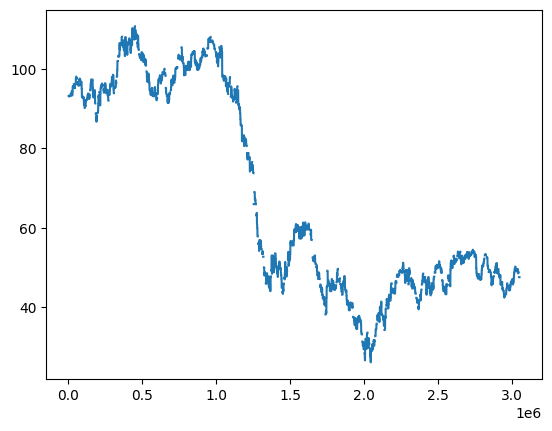

In [27]:
# check the oil_price column to see the best way to fill it missing values.

df_train['oil_price'].plot()

Because of the of the downtrend of the column it will be best to fill it with backfill.

In [28]:
# Fill the missing values in the 'oil_price' column using backward fill.

df_train['oil_price'].fillna(method='bfill', inplace=True)

<Axes: >

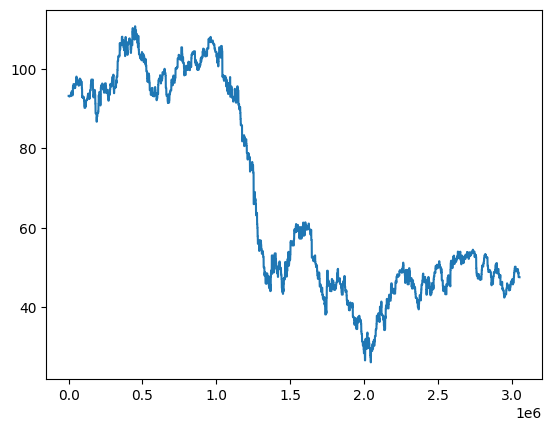

In [29]:
# Visualize the trend of oil prices after filling the missing values

df_train['oil_price'].plot()

In [30]:
# Confirm that there are no more missing values again in the column.

df_train.isna().sum().sum()

np.int64(0)

In [31]:
# Create the 'holiday_status' column

# Function to map holiday type to holiday status
def map_holiday_status(holiday_type):
    if holiday_type in ['No holiday', 'Work Day']:
        return 'No holiday'
    else:
        return 'Holiday'

# Add the 'holiday_status' column using the 'holiday_type' column
df_train['holiday_status'] = df_train['holiday_type'].apply(map_holiday_status)
df_train.head()

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,holiday_status
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday


In [32]:
# # Change the datatype of the date column to datetime.

df_train['date'] = pd.to_datetime(df_train['date'])

# Confirm the data type of the date column.

df_train['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3054348 entries, 0 to 3054347
Series name: date
Non-Null Count    Dtype         
--------------    -----         
3054348 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 23.3 MB


Because we are doing time series analysis it will be necessary to set date column as index column.

In [33]:
# Set date column as index column.

df_train.set_index('date', inplace=True)

**Feature creation**

In [34]:
# Create time series featurs based on time series index.

def create_feature(df_train):
    df_train['weekday'] = df_train.index.weekday
    df_train['month'] = df_train.index.month
    df_train['quarter'] = df_train.index.quarter 
    df_train['year'] = df_train.index.year
    return df_train

In [35]:
# Run the feature creation on the dataset.
df_train = create_feature(df_train)

In [36]:
# Check the feature creation.
create_feature(df_train).head()

,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,holiday_status,weekday,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013


In [37]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,3054348.0,27.500000,15.585787,1.000000,14.000000,27.500000,41.000000,54.000000
sales,3054348.0,359.020892,1107.285897,0.000000,0.000000,11.000000,196.011000,124717.000000
onpromotion,3054348.0,2.617480,12.254939,0.000000,0.000000,0.000000,0.000000,741.000000
transactions,3054348.0,1558.655862,1036.467605,0.000000,931.000000,1332.000000,1980.000000,8359.000000
oil_price,3054348.0,67.789300,25.702576,26.190001,46.279999,53.189999,95.800003,110.620003
cluster,3054348.0,8.481481,4.649735,1.000000,4.000000,8.500000,13.000000,17.000000
weekday,3054348.0,3.008168,2.001442,0.000000,1.000000,3.000000,5.000000,6.000000
month,3054348.0,6.222870,3.374251,1.000000,3.000000,6.000000,9.000000,12.000000
quarter,3054348.0,2.413652,1.095690,1.000000,1.000000,2.000000,3.000000,4.000000
year,3054348.0,2014.842474,1.345607,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000


- Sales have a wide range and high standard deviation, indicating significant variability in sales amounts.
- Onpromotion values are generally low, with most observations being zero, suggesting promotions might be infrequent or not widely utilized.
- Transactions also show high variability, with a mean of 1558.66 and a maximum of 8359.
- Oil prices range from 26.19 to 110.62, with a mean of 67.79, indicating fluctuations in the oil market during the observed period.

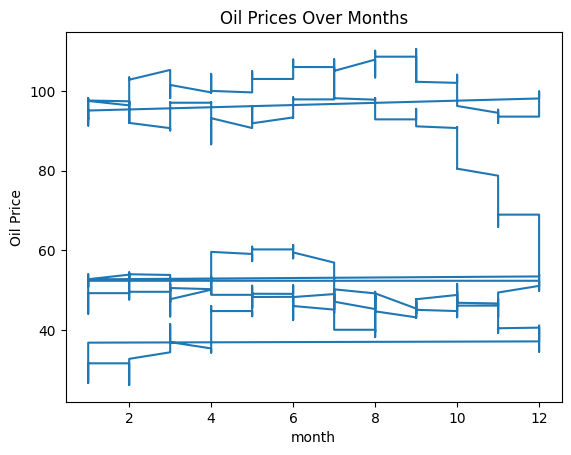

In [38]:
# Plot oil price over the monthly distribution
plt.plot(df_train['month'], df_train['oil_price'],)
plt.xlabel('month')
plt.ylabel('Oil Price')
plt.title('Oil Prices Over Months')
plt.show()

The plot shows three distinct oil price series, each with significant monthly volatility: the top series ranges between 80 and 110, the middle between 50 and 70, and the bottom between 30 and 50. While all series exhibit erratic fluctuations, the middle series appears relatively more stable than the others

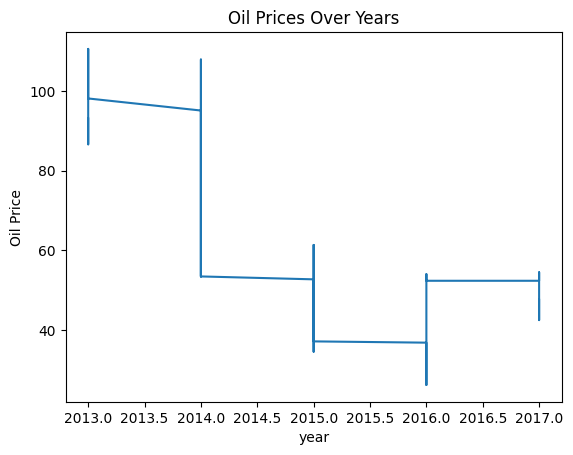

In [39]:
plt.plot(df_train['year'], df_train['oil_price'])
plt.xlabel('year')
plt.ylabel('Oil Price')
plt.title('Oil Prices Over Years')
plt.show()

The plot shows a general decline in oil prices from 2013 to 2017, with sharp drops around 2014 and 2015. While the prices stabilize somewhat after each drop, there are still noticeable fluctuations within each year.

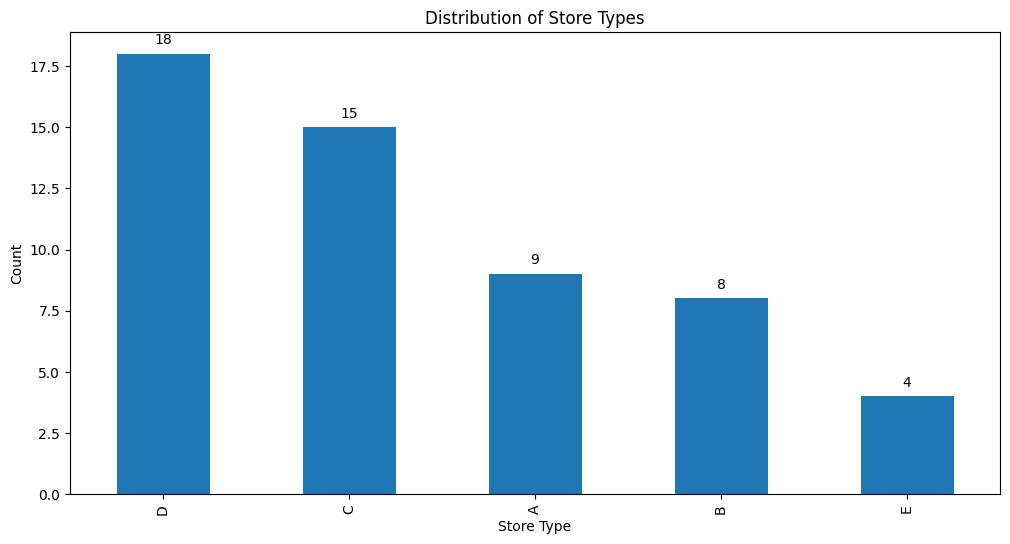

In [40]:
# Plotting the distribution of store types

plt.figure(figsize=(12, 6))
ax = stores['type'].value_counts().plot(kind='bar')

plt.xlabel('Store Type')
plt.ylabel('Count')
plt.title('Distribution of Store Types')

# Adding data labels (annotations) to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Type D is the most common, while Store Type E is the least common among the listed types.

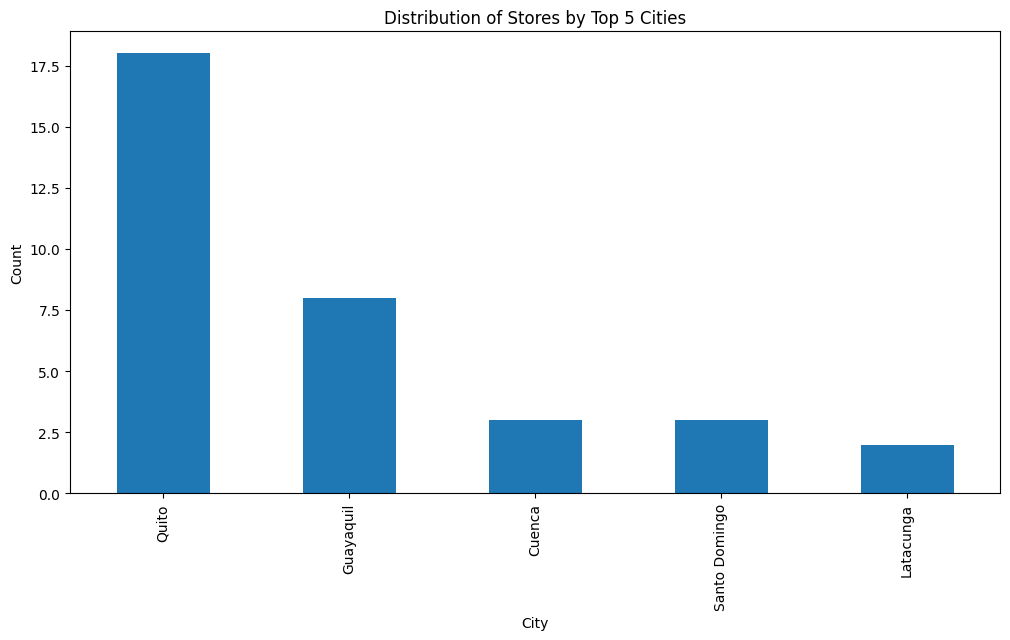

In [41]:
# Plotting the distribution of stores by top 5 cities
plt.figure(figsize=(12, 6))
stores['city'].value_counts().head(5).plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Distribution of Stores by Top 5 Cities')
plt.show()


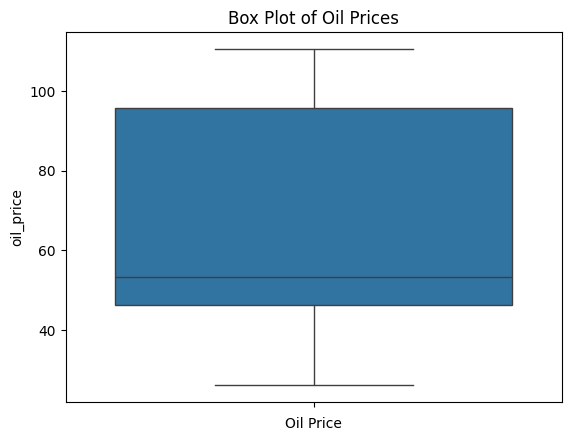

In [42]:
# Create the box plot of oil price to check outliers.
sns.boxplot(y=df_train['oil_price'])

# Add title and labels
plt.title('Box Plot of Oil Prices')
plt.xlabel('Oil Price')

# Show the plot
plt.show()



No outliers on the oil price

Text(0.5, 1.0, 'Histogram of Transactions')

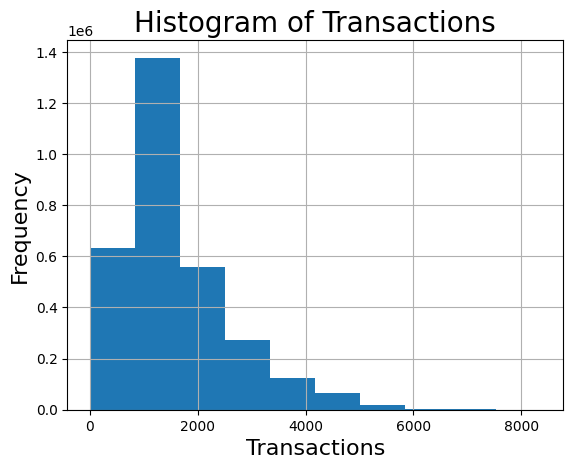

In [43]:
# Create a histogram of the 'transactions' column.

df_train.transactions.hist()
# Add labels to the x-axis, y-axis, and title
plt.xlabel('Transactions', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Transactions', fontsize=20)

# Show the plot

The histogram shows that most transactions fall within a certain range, around 800 to 1800, indicating a central trend. There is also a steady fall in the frequency of the transactions suggesting a steady transaction pattern.

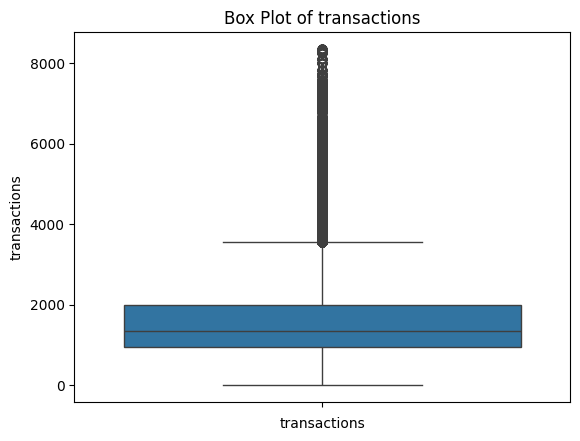

In [44]:
sns.boxplot(y=df_train['transactions'])

# Add title and labels
plt.title('Box Plot of transactions')
plt.xlabel('transactions')

# Show the plot
plt.show()

The box plot shows that the transactions fall within a certain range, around 800 to 1800, indicating a central trend. There are a few outliers, especially in the lower range, suggesting that there might be some transactions that are significantly higher or lower than the rest of the data.

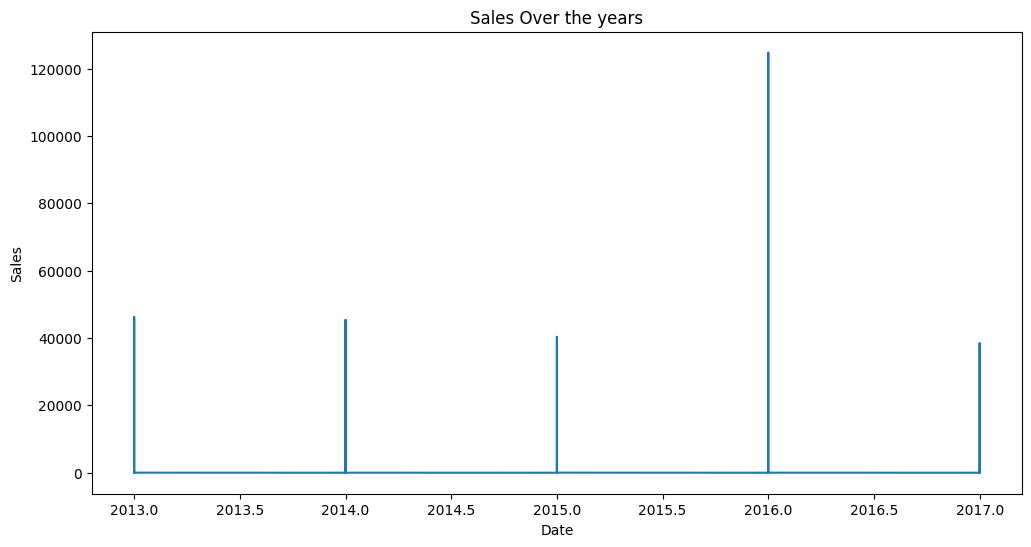

In [45]:
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(df_train['year'], df_train['sales'])
plt.title('Sales Over the years')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

The time series plot shows a general upward trend in sales over the years, with sales peaking in 2016 and then declining in 2017. There are also some fluctuations in sales during the 2014 and 2015 holidays.

#### **Hypothesis Test**

In [46]:
# Null Hypothesis (H₀): Holidays have impact on sales.
# Null Hypothesis (H₀): Holidays do not have impact on sales.

# Group data by holiday status
holiday_sales = df_train[df_train['holiday_status'] == 'holiday']['sales']
non_holiday_sales = df_train[df_train['holiday_status'] == 'No holiday']['sales']

# Perform a t-test
t_stat, p_value = ttest_ind(holiday_sales, non_holiday_sales)

# Define the significance level
alpha = 0.05


if p_value < alpha:
    print("Reject the null hypothesis: Holidays have a significant impact on sales.")
else:
    print("Fail to reject the null hypothesis: Holidays do not have a significant impact on sales.")




Fail to reject the null hypothesis: Holidays do not have a significant impact on sales.


### **Analitical Questions**

In [47]:
# Is the train dataset complete (has all the required dates)?

# Create a complete date range
date_range = pd.date_range(start=df_train.index.min(), end=df_train.index.max(), freq='D')

# Check for missing dates
missing_dates = date_range.difference(df_train.index)

if missing_dates.empty:
    print("The dataset contains all required dates.")
else:
    print(f"Missing dates: {missing_dates}")

Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [48]:
# Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

# Aggregate sales by date to ensure no duplicate dates
df = df_train.groupby(df_train.index).sum()

# Group by the existing 'year' column and find the date with the highest and lowest sales for each year
lowest_sales_dates = df.groupby('year')['sales'].idxmin()
highest_sales_dates = df.groupby('year')['sales'].idxmax()

# Get the sales values for those dates
lowest_sales_values = df.loc[lowest_sales_dates, 'sales'].values
highest_sales_values = df.loc[highest_sales_dates, 'sales'].values

# Combine the results into a DataFrame
results = pd.DataFrame({
    'Year': lowest_sales_dates.index,
    'Lowest Sales Date': lowest_sales_dates.values,
    'Lowest Sales Value': lowest_sales_values,
    'Highest Sales Date': highest_sales_dates.values,
    'Highest Sales Value': highest_sales_values
})

print(results)


        Year Lowest Sales Date  Lowest Sales Value Highest Sales Date  \
0    3587166        2013-01-01        2.511619e+03         2013-12-23   
1    3588948        2014-01-01        8.602065e+03         2014-12-23   
2    3590730        2015-01-01        1.277362e+04         2015-10-04   
3    3592512        2016-01-01        1.643339e+04         2016-04-18   
4    3594294        2017-01-01        1.208250e+04         2017-04-01   
5    7174332        2013-07-03        7.491038e+05         2013-12-22   
6    7177896        2014-07-03        1.167689e+06         2014-12-22   
7    7181460        2015-07-03        1.545547e+06         2015-12-22   
8    7185024        2016-05-12        1.206788e+06         2016-05-01   
9    7188588        2017-04-14        1.481779e+06         2017-07-03   
10  10761498        2013-06-25        9.153586e+05         2013-06-25   
11  10772190        2015-06-25        1.556103e+06         2015-06-25   
12  10777536        2016-06-25        2.580891e+06 

The sales data shows that the lowest sales values often occur on January 1st, likely due to New Year's Day, while the highest sales values tend to be around late December, indicating strong holiday season sales. There is a notable increase in the highest sales values over the years, suggesting overall sales growth, but some anomalies and duplicate year entries warrant further investigation for data consistency.

The highest sales occurred in 2016-12 with a sales value of 30776136.9704691.


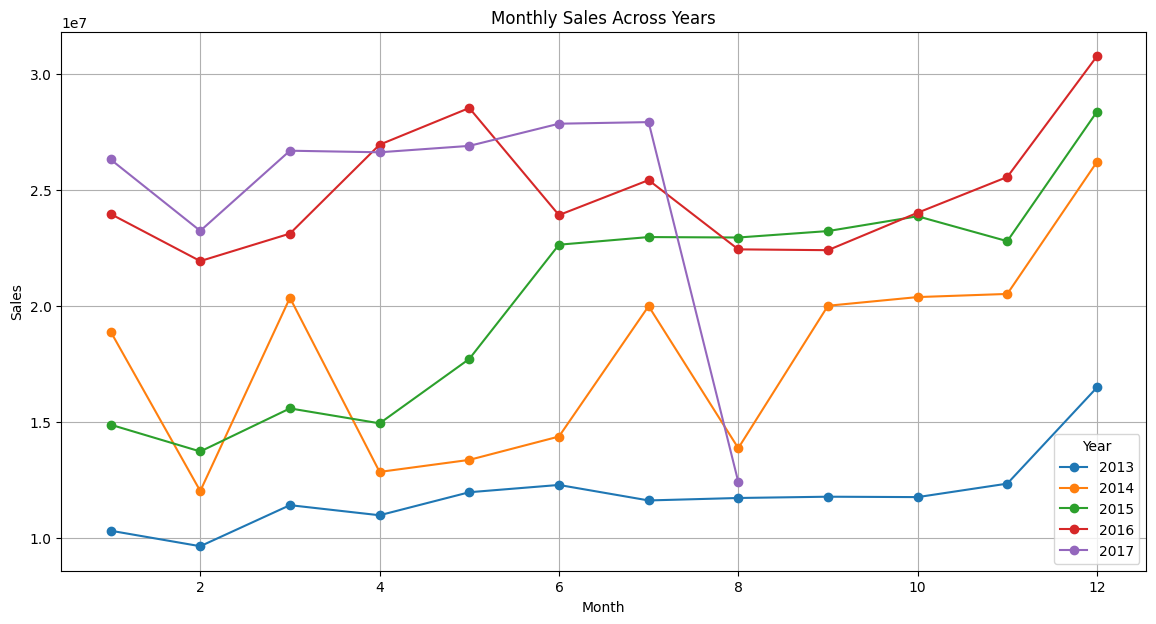

In [49]:
# Compare the sales for each month across the years and determine which month of which year had the highest sales.

# Aggregate sales by month and year
monthly_sales = df_train.groupby(['year', 'month'])['sales'].sum().reset_index()

# Find the month with the highest sales
max_sales_row = monthly_sales.loc[monthly_sales['sales'].idxmax()]
max_year = int(max_sales_row['year'])
max_month = int(max_sales_row['month'])
max_sales_value = max_sales_row['sales']

print(f"The highest sales occurred in {max_year}-{max_month:02d} with a sales value of {max_sales_value}.")

# Plotting the sales for each month across the years
plt.figure(figsize=(14, 7))
for year in monthly_sales['year'].unique():
    plt.plot(
        monthly_sales[monthly_sales['year'] == year]['month'],
        monthly_sales[monthly_sales['year'] == year]['sales'],
        marker='o',
        label=str(year)
    )

plt.title('Monthly Sales Across Years')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.grid(True)
plt.show()


The plot shows that December consistently has high sales across all years, with a notable peak in December 2014, indicating strong end-of-year sales activity likely due to the holiday season. Additionally, the mid-year months, particularly around June, also exhibit significant sales increases in some years, reflecting potential mid-year promotions or events.

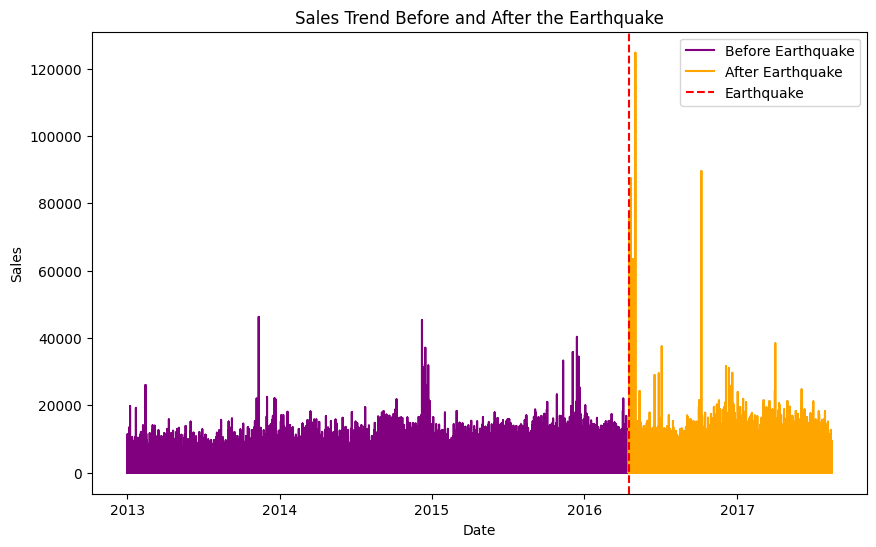

In [50]:
#  Did the earthquake impact sales?

# Convert 'date' from index to a regular column
df_train.reset_index(inplace=True)

# Filter the data for the period before and after the earthquake
before_earthquake_df = df_train[df_train['date'] < '2016-04-16']
after_earthquake_df = df_train[df_train['date'] >= '2016-04-16']

# Visualize the impact of the earthquake on sales
plt.figure(figsize=(10, 6))
plt.plot(before_earthquake_df['date'], before_earthquake_df['sales'], color='purple', label='Before Earthquake')
plt.plot(after_earthquake_df['date'], after_earthquake_df['sales'], color='orange', label='After Earthquake')
plt.axvline(x=pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Before and After the Earthquake')
plt.legend()
plt.show()

# Revert 'date' back to an index
df_train.set_index('date', inplace=True)

The plot shows a clear distinction in sales trends before and after the earthquake on April 16, 2016, indicated by the red dashed line. Before the earthquake, sales were relatively stable with occasional spikes, while after the earthquake, sales exhibited more variability and several notable peaks, suggesting a significant impact on sales patterns post-event.

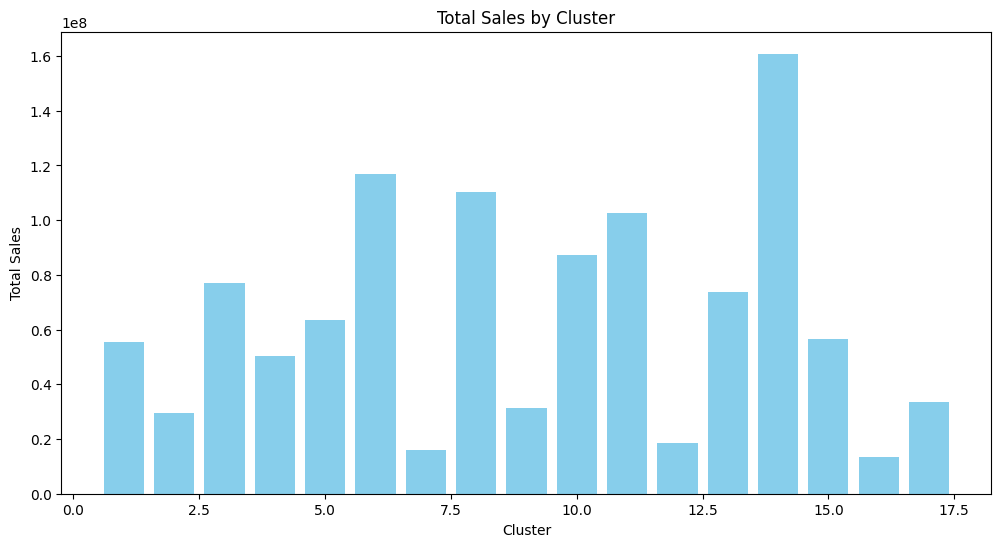

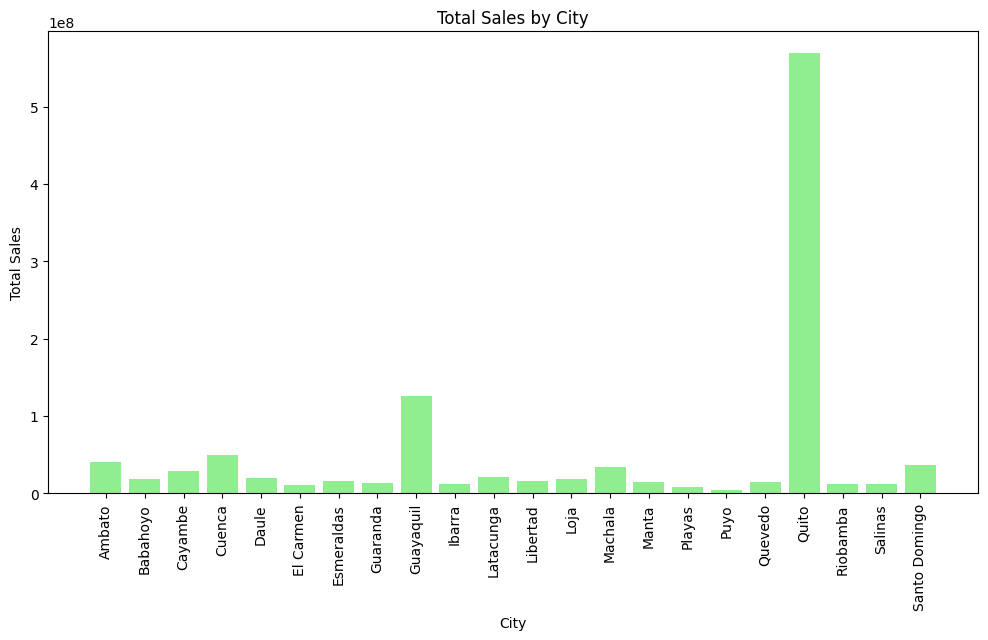

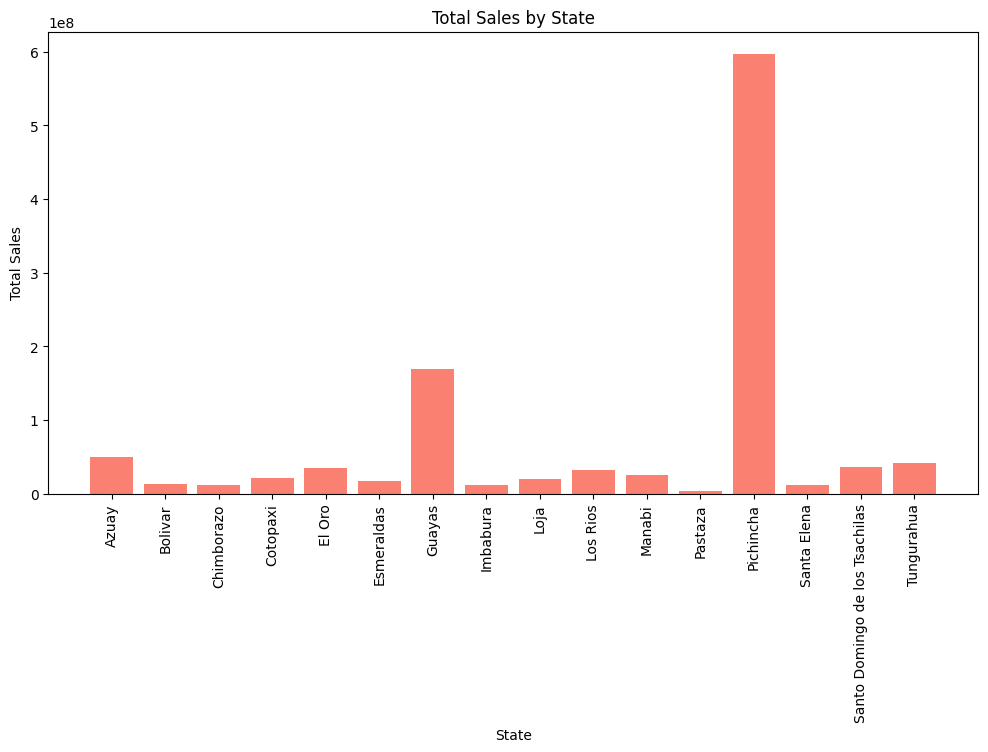

In [51]:
# Are certain stores or groups of stores selling more products? (Cluster, city, state, type)


# Summarize sales by different groupings
sales_by_cluster = df_train.groupby('cluster')['sales'].sum().reset_index()
sales_by_city = df_train.groupby('city')['sales'].sum().reset_index()
sales_by_state = df_train.groupby('state')['sales'].sum().reset_index()

# Plot the sales by cluster
plt.figure(figsize=(12, 6))
plt.bar(sales_by_cluster['cluster'], sales_by_cluster['sales'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.title('Total Sales by Cluster')
plt.show()

# Plot the sales by city
plt.figure(figsize=(12, 6))
plt.bar(sales_by_city['city'], sales_by_city['sales'], color='lightgreen')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.title('Total Sales by City')
plt.xticks(rotation=90)
plt.show()

# Plot the sales by state
plt.figure(figsize=(12, 6))
plt.bar(sales_by_state['state'], sales_by_state['sales'], color='salmon')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.title('Total Sales by State')
plt.xticks(rotation=90)
plt.show()




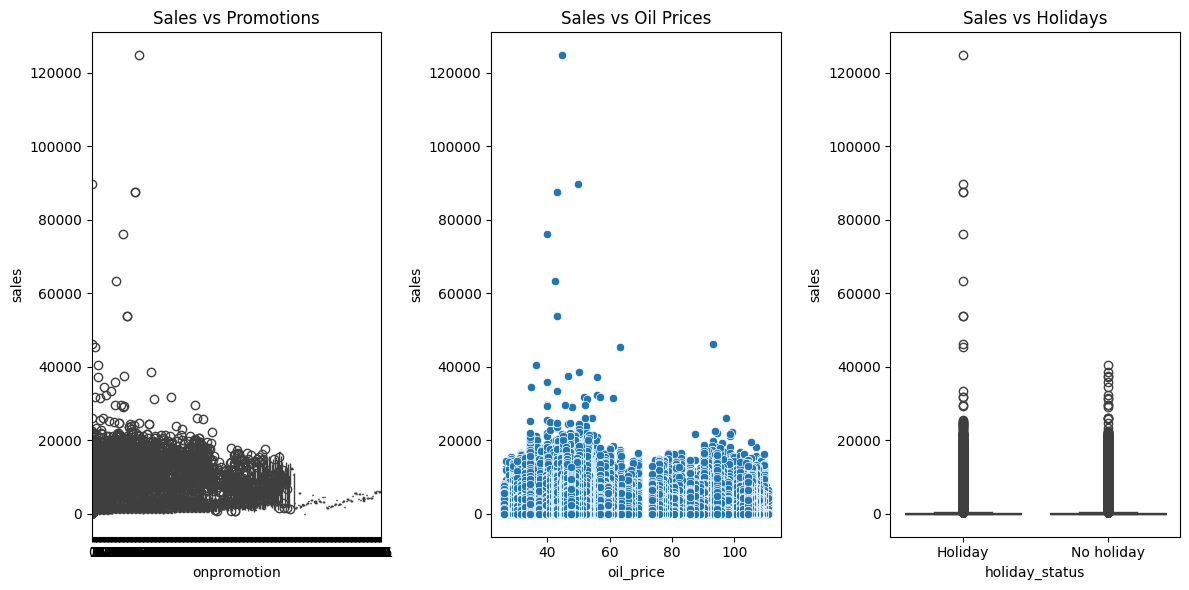

In [52]:
# Are sales affected by promotions, oil prices and holidays?

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='onpromotion', y='sales', data=df_train)
plt.title('Sales vs Promotions')

plt.subplot(1, 3, 2)
sns.scatterplot(x='oil_price', y='sales', data=df_train)
plt.title('Sales vs Oil Prices')

plt.subplot(1, 3, 3)
sns.boxplot(x='holiday_status', y='sales', data=df_train)
plt.title('Sales vs Holidays')

plt.tight_layout()
plt.show()


The scatter plots show that there is a high variance in sales regardless of the number of promotions, oil prices, or holiday status, with many outliers indicating extremely high sales. Overall, sales tend to cluster at lower values in each plot, suggesting that these factors may not have a strong linear correlation with sales.

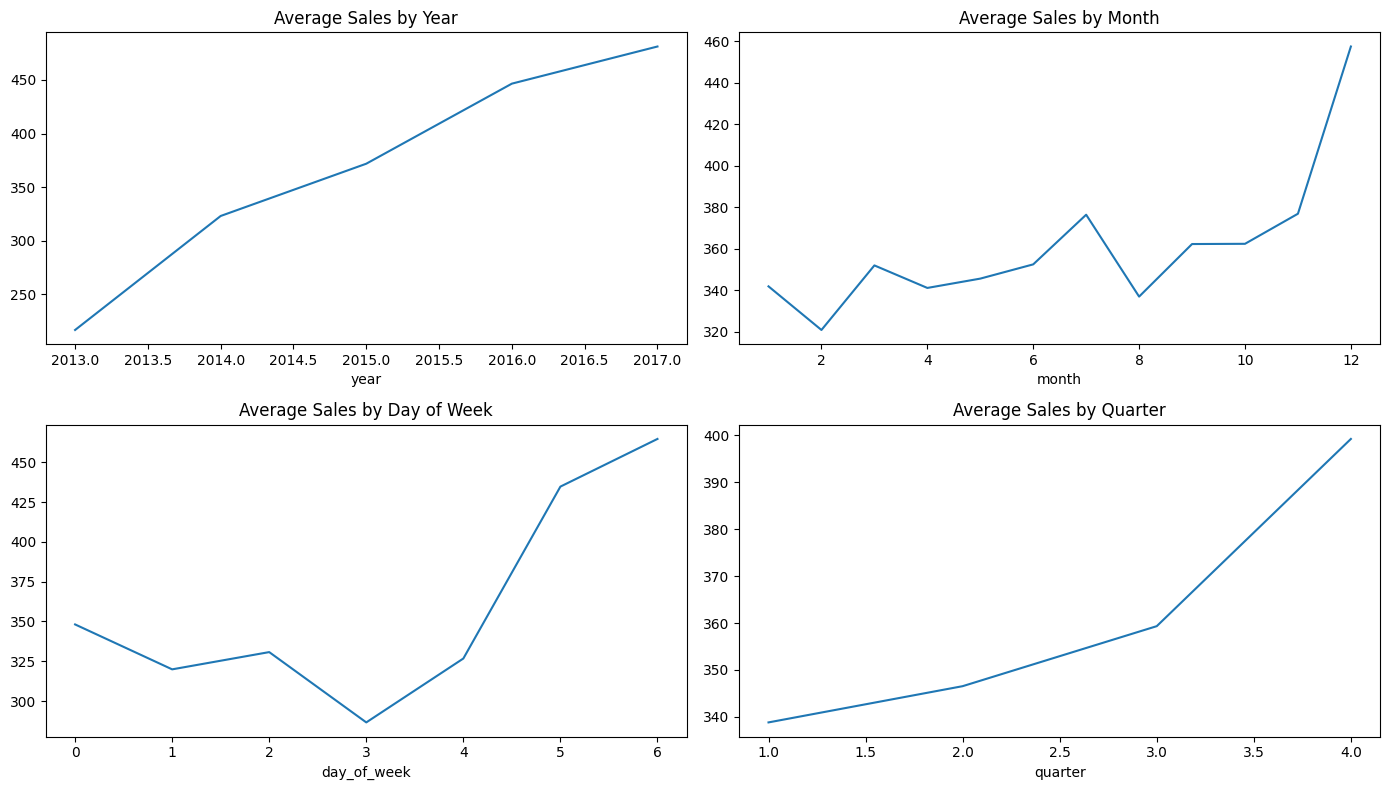

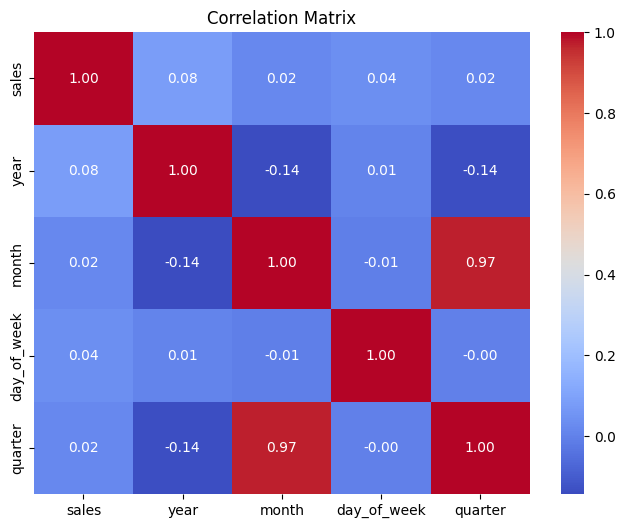

In [53]:
#  What analysis can we get from the date and its extractable features?

# Sales Trends Over Time

df_train['year'] = df_train.index.year
df_train['month'] = df_train.index.month
df_train['day_of_week'] = df_train.index.dayofweek
df_train['quarter'] = df_train.index.quarter

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
df_train.groupby('year')['sales'].mean().plot()
plt.title('Average Sales by Year')

plt.subplot(2, 2, 2)
df_train.groupby('month')['sales'].mean().plot()
plt.title('Average Sales by Month')

plt.subplot(2, 2, 3)
df_train.groupby('day_of_week')['sales'].mean().plot()
plt.title('Average Sales by Day of Week')

plt.subplot(2, 2, 4)
df_train.groupby('quarter')['sales'].mean().plot()
plt.title('Average Sales by Quarter')

plt.tight_layout()
plt.show()


# Sales Heatmap by Day of Week and Month
correlation_matrix = df_train[['sales', 'year', 'month', 'day_of_week', 'quarter']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [54]:
# Which product family and stores did the promotions affect.






 **What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)**

MAE (Mean Absolute Error) measures the average absolute difference between predicted and actual values. It is less sensitive to outliers but generally larger than RMSE and MSE.

MSE (Mean Squared Error) measures the average squared difference between predicted and actual values. It gives more weight to large errors, making it sensitive to outliers.

RMSE (Root Mean Squared Error) is the square root of MSE and has the same sensitivity to outliers as MSE but is more interpretable.

RMSLE (Root Mean Squared Logarithmic Error) is useful when relative errors matter more than absolute errors and is less sensitive to outliers in the target variable.

MAE is generally greater than RMSE and MSE because it does not penalize larger errors as heavily as squared-error metrics.

Text(0.5, 1.0, 'Sales on the 15th Day')

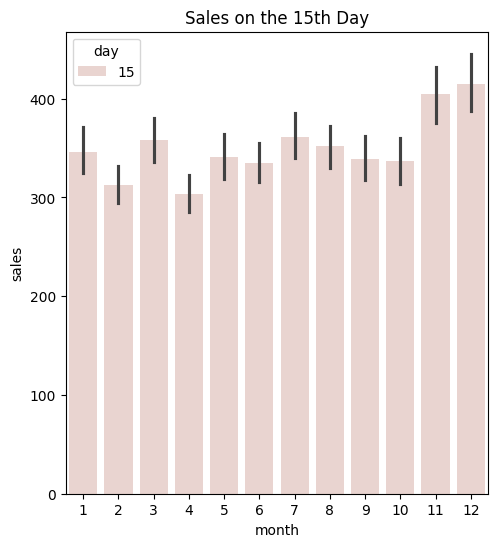

In [55]:
#  Does the payment of wages in the public sector on the 15th and last days of the month influence the store.

# Filter the data for the 15th and last days of the month

df_train['day'] = df_train.index.day

first_15th_df = df_train[df_train['day'] == 15]
last_day_df = df_train[df_train['day'] == df_train['day'].max()]

# Plot the sales on the 15th and last days of the month

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='month', y='sales', hue='day', data=first_15th_df)
plt.title('Sales on the 15th Day')


The bar plot shows the average sales on the 15th day of each month, with a general increasing trend observed from January to December. Notably, sales peak in the months of November and December, indicating higher sales activity during these months.

In [56]:
# Save the train dataset as a csv, create a new copy, then carry out feature engineering on the new copy

# df_train.to_csv('corporation_favotita_sales.csv',na_rep='')

**Data Preparation, Modeling,  Evaluation**

**AutoRegressive Integrated Moving Average (ARIMA)**

In [57]:
# AutoRegressive Integrated Moving Average (ARIMA)

# Downsample the data to monthly frequency by summing up sales within each month
df_monthly = df_train['sales'].resample('M').sum()

# Split the data into training and testing sets
train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly[:train_size], df_monthly[train_size:]

# Train the ARIMA model
model = ARIMA(train, order=(5, 1, 0))  # The order (p, d, q) needs to be chosen appropriately
model_fit = model.fit()

# Forecast the test set
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Evaluate the model
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 3293656.1180246486
MSE: 19987020251342.28
RMSE: 4470684.539457272


**Linear Regression**

In [58]:
# Linear Regression.

# Dropping columns that are not needed for the model
df = df_train.drop(columns=['description', 'transferred', 'holiday_type', 'locale', 'locale_name'])

# Identify all object-type columns (categorical variables)
object_cols = df.select_dtypes(include=['object']).columns.tolist()

# Convert categorical variables into dummy/indicator variables
df = pd.get_dummies(df, columns=object_cols, drop_first=True)

# Separate features and target variable
X = df.drop(columns=['sales'])
y = df['sales']

# Split the data into training and testing sets (assuming you haven't done it already)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 302.012864573407
Mean Squared Error (MSE): 489727.0964628663
Root Mean Squared Error (RMSE): 699.805041752963


**XGBoost**

In [59]:
# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=10, n_estimators=100)

# Train the model on the training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 135.0818743201462
Mean Squared Error (MSE): 135129.98816001005
Root Mean Squared Error (RMSE): 367.6003103372058


In [ ]:
# Create and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
 
# Make predictions
y_pred_rf = rf_model.predict(X_test)
 
# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
 
print(f'Random Forest MSE: {mse_rf}')
print(f'Random Forest RMSE: {rmse_rf}')
print(f'Random Forest R2: {r2_rf}')
# Create and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
 
# Make predictions
y_pred_rf = rf_model.predict(X_test)
 
# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
 
print(f'Random Forest MSE: {mse_rf}')
print(f'Random Forest RMSE: {rmse_rf}')
print(f'Random Forest R2: {r2_rf}')


**Mean Absolute Error (MAE):**

ARIMA has the highest MAE, indicating it has the largest average error.
Linear Regression has a significantly lower MAE compared to ARIMA.
XGBoost has the lowest MAE, indicating it has the smallest average error among the three models.

**Mean Squared Error (MSE):**  

ARIMA's MSE is extremely high, suggesting it has large deviations from the actual values.
Linear Regression's MSE is much lower than ARIMA's.
XGBoost has the lowest MSE, indicating it has the smallest squared deviations from the actual values.

**Root Mean Squared Error (RMSE):**

ARIMA has the highest RMSE, indicating large overall errors.
Linear Regression's RMSE is significantly lower than ARIMA's.
XGBoost has the lowest RMSE, indicating it has the smallest overall errors among the three models.

**Best Model:**
Based on the provided evaluation metrics, XGBoost performs the best, with the lowest MAE, MSE, and RMSE. This suggests that XGBoost has the highest accuracy and the smallest prediction errors in comparison to ARIMA and Linear Regression.








**Hyperparameter tuning on the best model**

In [69]:

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(1, 2)
}

# Split a smaller subset of data for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

# Initialize RandomizedSearchCV with custom cross-validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
custom_cv = [(train_idx, val_idx) for train_idx, val_idx in kfold.split(X_sample)]

# Function to perform fit with early stopping
def xgb_fit_with_early_stopping(X_train, y_train, X_val, y_val, **kwargs):
    model = XGBRegressor(**kwargs)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False
    )
    return model

# Custom scoring function for RandomizedSearchCV
def custom_scoring(estimator, X, y):
    val_idx = int(len(X) * 0.2)  # Use 20% of the data for validation
    X_train, X_val = X[:-val_idx], X[-val_idx:]
    y_train, y_val = y[:-val_idx], y[-val_idx:]
    model = xgb_fit_with_early_stopping(X_train, y_train, X_val, y_val, **estimator.get_params())
    return model.score(X_val, y_val)

# Initialize RandomizedSearchCV with fewer iterations and custom scoring
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=param_dist,
    n_iter=20,
    cv=custom_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring=custom_scoring
)

# Fit the random search to the smaller data subset
random_search.fit(X_sample, y_sample)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'colsample_bytree': np.float64(0.749816047538945), 'gamma': np.float64(0.2852142919229748), 'learning_rate': np.float64(0.15639878836228102), 'max_depth': 7, 'n_estimators': 70, 'reg_alpha': np.float64(0.07800932022121826), 'reg_lambda': np.float64(1.3119890406724053), 'subsample': np.float64(0.6232334448672797)}
Best cross-validation score: nan


Hyperparameter tuning for XGBoost optimizes its performance by finding the best combination of parameters such as learning rate, tree depth, and number of estimators, which enhances its ability to fit the training data and generalize to unseen data. This process leads to improved accuracy, reduced overfitting, and a more robust model.

**Backtesting**

In [73]:



# Convert all categorical columns to strings
for col in categorical_features:
    df_train[col] = df_train[col].astype(str)

# Convert boolean columns to integers if necessary
for col in df_train.select_dtypes(include='bool').columns:
    df_train[col] = df_train[col].astype(int)

# Define X and y
X = df_train[features]
y = df_train[target]

# Define preprocessing for numerical and categorical data
numerical_features = [col for col in features if col not in categorical_features]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6))
])

# Define time-based split
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

mse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

print(f'Average Mean Squared Error: {np.mean(mse_scores)}')


Average Mean Squared Error: 178746.31768193626


Backtesting with XGBoost involves training the model on historical data and testing it on subsequent time periods to evaluate its predictive performance. This approach helps assess how well the model generalizes to unseen data over time, providing insights into its robustness and accuracy in a real-world scenario.

**Conlusion** 

The analysis of the Corporation Favorita time series data for sales prediction effectively combines data exploration, feature engineering, and advanced machine learning techniques like XGBoost. Through comprehensive data exploration and analysis, key business questions were addressed, leading to a robust model optimized by hyperparameter tuning and validated through backtesting. This approach ensures accurate forecasts and provides valuable insights for strategic decision-making and inventory management.